# Machine Learning: Web Classification
During my internship at Jewel Paymentech, I undertook an independent data science project to build a machine learning model that performs multi-class classfication of websites based on its text data.

## Project Objective
The objective of this project is to assist our clients in identifying various categories of potentially illegal or fraudulent website content such as pornography, gambling and multi-level marketing (based on the website's text content).

## Machine Learning Pipeline
This is an overview of a typical machine learning pipeline. To prepare my data for model training, data cleaning and text preprocessing will be performed to ensure the data is of 'good quality'.

<img src="machine_learning_pipeline.png">

In [1]:
import io
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import Counter

from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Sklearn Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

# Imbalanced-Learn Libraries
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

### Read Text Data from File Directories

In [3]:
PORN = 'Porn'
PROSTITUTION = 'Prostitution'
WEAPON = 'Weapon'
TMS = 'Tms'
TRIAL = 'Trial'
PENNY = 'Penny'
COUNTERFEIT = 'Counterfeit'
CYBERLOCKER = 'Cyberlocker'
MLM = 'Mlm'
PHARMA = 'Pharma'
SMOKE = 'Smoke'
SPAM = 'Spam'
CASINO = 'Casino'
ALCOHOL = 'Alcohol'
NORMAL = 'Normal'

path = '../' + dataset_filepath

SOURCES = [
    (path + '/PORN',         PORN),
    (path + '/PROSTITUTION', PROSTITUTION),
    (path + '/WEAPON',       WEAPON),
    (path + '/TMS',          TMS),
    (path + '/TRIAL',        TRIAL),
    (path + '/PENNY',        PENNY),
    (path + '/COUNTERFEIT',  COUNTERFEIT),
    (path + '/CYBERLOCKER',  CYBERLOCKER),
    (path + '/MLM',          MLM),
    (path + '/PHARMA',       PHARMA),
    (path + '/SMOKE',        SMOKE),
    (path + '/SPAM',         SPAM),
    (path + '/CASINO',       CASINO),
    (path + '/ALCOHOL',      ALCOHOL),
    (path + '/NORMAL',       NORMAL)
]

NEWLINE = '\n'
SKIP_FILES = {'cmds'}

def read_files(path):
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):                
                    lines = []
                    # Use io.open instead for Python 2.0, open()takes no encoding argument. The third argument is the buffering option instead.
                    f = io.open(file_path, encoding = 'latin-1')
                    for line in f:
                        lines.append(line)
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content

def build_data_frame(path, classification):
    rows = []
    index = []
    for file_name, text in read_files(path):
        rows.append({'text': text, 'class': classification})
        index.append(file_name[38:])
    data_frame = DataFrame(rows, index=index)
    return data_frame


d = ({'text':[], 'class':[]})

df = DataFrame(data = d)

for path, classification in SOURCES:
    df = df.append(build_data_frame(path, classification))
df = df.reindex(np.random.permutation(df.index))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7181 entries, dataset/balance_hotel_ovr_560sites/WEAPON/www.edbrown.com copy 2.txt to dataset/balance_hotel_ovr_560sites/WEAPON/www.aledge.com copy 3.txt
Data columns (total 2 columns):
class    7181 non-null object
text     7181 non-null object
dtypes: object(2)
memory usage: 168.3+ KB


In [14]:
df['text'].nunique()

2366

In [15]:
new_df = df.drop_duplicates(subset='text')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2366 entries, dataset/balance_hotel_ovr_560sites/WEAPON/www.edbrown.com copy 2.txt to dataset/balance_hotel_ovr_560sites/WEAPON/www.aledge.com copy 3.txt
Data columns (total 2 columns):
class    2366 non-null object
text     2366 non-null object
dtypes: object(2)
memory usage: 55.5+ KB


In [16]:
print(new_df.nunique())
print()
print(new_df.duplicated().any())

class      15
text     2366
dtype: int64

False


### Class Distribution

In [8]:
new_df['class'].value_counts()

Normal          570
Porn            188
Pharma          183
Casino          180
Alcohol         172
Smoke           169
Mlm             155
Weapon          138
Penny           136
Spam            121
Counterfeit     100
Cyberlocker      85
Prostitution     73
Tms              63
Trial            33
Name: class, dtype: int64

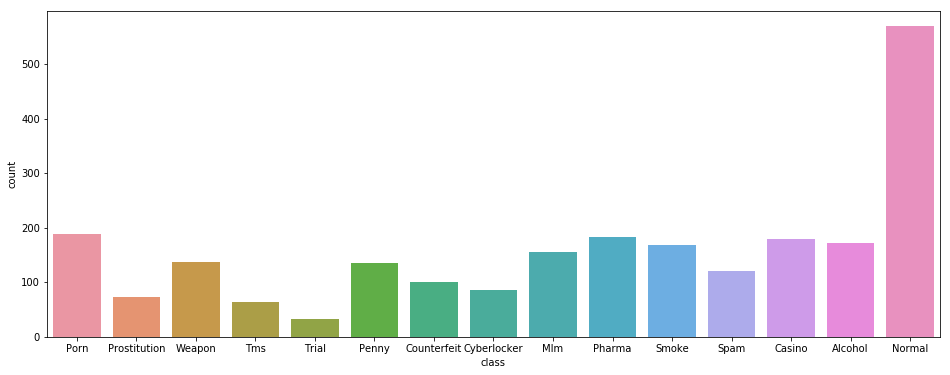

In [10]:
# Plot Class Distribution
plt.figure(figsize=(16,6))
sns.countplot(new_df['class'])
plt.show()

### Clean Dataset

Clean text to remove irrelevant text such as non-letters, whitespace, HTML tags, and stopwords. Stopwords are commonly used words such as 'a', 'am', 'as', etc.

In [2]:
# text pre-processing for English sites only, other languages are not supported!
def clean_text(raw_text, remove_stopwords=False):
    # 1. remove HTML
    # 2. remove non-letters
    # 3. convert words to lower case
    # 4. remove whitespace
    # 5. chop sentences into words
    # 6. optionally remove stop words (false by default)
    # 7. return a long string of words

    html_text = BeautifulSoup(raw_text, 'html.parser').get_text()
    non_letters = re.sub('[^a-zA-Z]', ' ', html_text)
    words = non_letters.lower()
    words = ' '.join(words.split())
    words = words.split()
    if remove_stopwords:
        # 7. return a long string of words
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    return words

### Text Preprocessing

Word lemmatization is a NLP technique used to transform a word into its root form, allowing grouping of similar words. E.g. the root form of 'walks', 'walked', 'walking' is equivalent to 'walk'.

In [4]:
def word_lemmatization(text):
    lemm = WordNetLemmatizer()
    
    def get_pos(word):
        w_synsets = wordnet.synsets(word)

        pos_counts = Counter()
        pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
        pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
        pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
        pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )

        most_common_pos_list = pos_counts.most_common(3)
        return most_common_pos_list[0][0]
    
    return [lemm.lemmatize(word, pos=get_pos(word)) for word in nltk.word_tokenize(text)]

In [14]:
# Read & Clean Dataset (in Pandas)
df = pd.read_csv('dataset.csv')
df = df.dropna()
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(lambda x: ' '.join(x))
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split(' ') if len(w) > 1]))
df['text'] = df['text'].apply(lambda x: ' '.join(word_lemmatization(x)))

# Features
X = df['text'].values
# Response
y = df['class'].values

### Train-Test-Split

Splitting the data into training and testing sets is essential for evaluating predictive model's performance. The training set will be used to train the model while the testing data is used to evaluate the model's performance.

In [15]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y, shuffle=True)

### Machine Learning

Term Frequency-Inverse Document Frequency (TF-IDF) is an information retrieval technique used to normalize the frequencies of word occurences by scaling down the impact of words that frequently appears. 

The machine learning algorithm I used are _Linear Support Vector Classifier_ and _Multinomial Naive Bayes_.

### Hyperparameter Optimization
Perform search on various hyperparameters to find the optimal set of parameters that enhances the model's performance.

#### Multinomial Naive Bayes (OneVsRest)

In [9]:
clf_pipeline = imbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('oversample', SMOTE(random_state=2)),
    ('clf', OneVsRestClassifier(MultinomialNB()))
])

parameters = {
    'tfidf__encoding': ['latin-1'],
    'tfidf__lowercase': [True],
    'tfidf__stop_words': ['english'],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__use_idf': [False, True],
    'tfidf__smooth_idf': [False, True],
    'tfidf__sublinear_tf': [False, True],
    'clf__estimator__alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__estimator__fit_prior': [True, False]
}

print("Performing grid search...")
t0 = time()

grid = GridSearchCV(clf_pipeline, parameters, n_jobs=-1, cv=5, scoring = 'accuracy')

grid.fit(X_train, y_train)
print("Finish training in %fs" % (time() - t0))

joblib.dump(grid, 'nb_model.pkl', protocol=-1)
print('Saved Model')

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Performing grid search...
Finish training in 4982.342403s
Saved Model
0.767975830816
{'clf__estimator__alpha': 1, 'clf__estimator__fit_prior': True, 'tfidf__encoding': 'latin-1', 'tfidf__lowercase': True, 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True}
Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...Classifier(estimator=MultinomialNB(alpha=1, class_prior=None, fit_prior=True),
          n_jobs=1))])


In [16]:
model = joblib.load('nb_model.pkl')

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

     Alcohol       0.89      0.90      0.90        52
      Casino       0.82      0.98      0.89        54
 Counterfeit       0.75      0.90      0.82        30
 Cyberlocker       0.80      0.80      0.80        25
         Mlm       0.73      0.74      0.74        47
      Normal       0.92      0.50      0.65       171
       Penny       0.79      0.80      0.80        41
      Pharma       0.87      0.96      0.91        55
        Porn       0.78      0.82      0.80        56
Prostitution       0.82      0.82      0.82        22
       Smoke       0.98      0.88      0.93        51
        Spam       0.43      0.97      0.60        36
         Tms       0.59      0.84      0.70        19
       Trial       0.07      0.10      0.08        10
      Weapon       0.92      0.88      0.90        41

 avg / total       0.82      0.77      0.77       710



#### SVM

In [8]:
clf_pipeline = imbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('oversample', SMOTE(random_state=2)),
    ('svm', OneVsRestClassifier(LinearSVC()))
])

parameters = {
    'tfidf__encoding': ['latin-1'],
    'tfidf__lowercase': [True],
    'tfidf__stop_words': ['english'],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__use_idf': [False, True],
    'tfidf__smooth_idf': [False, True],
    'tfidf__sublinear_tf': [False, True],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "svm__estimator__C": [0.01, 0.1, 1],
    "svm__estimator__class_weight": ['balanced', None]
}

print("Performing grid search...")
t0 = time()

grid = GridSearchCV(clf_pipeline, parameters, n_jobs=-1, cv=3, scoring='accuracy')

grid.fit(X_train, y_train)
print("Finish training in %fs" % (time() - t0))

joblib.dump(grid, 'svm_model.pkl', protocol=-1)
print('Saved Model')

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Performing grid search...
Finish training in 30291.770368s
Saved Model
0.865256797583
{'svm__estimator__C': 1, 'svm__estimator__class_weight': None, 'tfidf__encoding': 'latin-1', 'tfidf__lowercase': True, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False}
Pipeline(memory=None,
    steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=False...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])


In [15]:
model = joblib.load('svm_model.pkl')

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

     Alcohol       0.96      0.94      0.95        52
      Casino       0.96      0.96      0.96        54
 Counterfeit       0.72      0.97      0.83        30
 Cyberlocker       0.88      0.88      0.88        25
         Mlm       0.78      0.77      0.77        47
      Normal       0.85      0.89      0.87       171
       Penny       0.89      0.80      0.85        41
      Pharma       0.91      0.96      0.94        55
        Porn       0.87      0.86      0.86        56
Prostitution       0.81      0.77      0.79        22
       Smoke       1.00      0.90      0.95        51
        Spam       0.97      0.86      0.91        36
         Tms       0.89      0.89      0.89        19
       Trial       0.20      0.10      0.13        10
      Weapon       0.86      0.88      0.87        41

 avg / total       0.88      0.88      0.88       710



### Model Evaluation

Metrics used to evaluate a classification model include True-Positive and False-Positive Rate of the model's predictions. The following below is a confusion matrix which depicts the True-Positve and False-Positive Rate of the model's predictions.

The model performs generally well on most classes except for the 'Trial' class. This is due to the small amount of samples we have for the 'Trial' class. As such, to further improve the model performance, it is best to collect more data on the 'Trial' class.

<img src="confusion_matrix.png">

# Deep Learning Applications for NLP

Here, I will be implementing a deep learning neural network architecture to perform classification of websites based on its text data. Similar to the machine learning pipeline shown previously, I will be preprocessing the text and splitting the data into train and test datasets.

The neural network I will be building here is **LSTM** (Long-Short-Term Memory), a type of recurrent neural network. It takes into account the sequence of the inputs, by feeding the output from the previous step as input to the current step. 

In the neural network architecture I am building, I will also be utilizing a pre-trained word embedding model (Glove). Word embeddings are essentially vector representations of text; it is able to capture context of a word in a document, semantic similarity, and relation with other words.

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import (Dense, Dropout, Embedding, Input, Flatten, Conv1D, BatchNormalization, Activation,
                          GlobalMaxPooling1D, MaxPooling1D, LSTM, Bidirectional)
from keras.models import Model
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, Adadelta
from keras import regularizers

### Load Pre-trained Word Embedding (Glove)

In [2]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [3]:
glove = loadGloveModel('glove.6B.300d.txt')

### Text Preprocessing

In [7]:
def preprocess_text(texts, MAX_WORDS, MAX_SEQUENCE_LENGTH):
    '''Preprocess text: Tokenize text to sequence; Pad sequence of text data
    Returns processed text data'''
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    return data, word_index

### Train-Test-Split

In [8]:
def split_data(data, labels, VALIDATION_SPLIT):
    '''Splits data based on validation size and one-hot encodes labels
    Returns: X_train, X_test, Y_train, Y_test
    '''
    
    X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=VALIDATION_SPLIT, 
                                                        stratify=labels, shuffle=True, random_state=42)

    Y_train = to_categorical(np.asarray(Y_train))
    Y_test = to_categorical(np.asarray(Y_test))
    
    return X_train, X_test, Y_train, Y_test

In [9]:
df = pd.read_csv('dataset.csv')
texts = df['text']
labels = df['class'].factorize()[0]

### Keras Embedding

In [10]:
def get_embedding_layer(glove, word_index, EMBEDDING_DIM):
    '''Prepares embedding matrix using pre-trained word vector (GLOVE) and 
    builds an Embedding layer using the matrix. Returns Embedding Layer'''
    
    # prepare embedding matrix
    num_words = min(MAX_WORDS, len(word_index)) + 1
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > MAX_WORDS:
            continue
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    
    return embedding_layer

### LSTM

In [11]:
def lstm_model():

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
    x = Dense(256, activation='relu')(l_lstm)
    x = Dense(128, activation='relu')(x)
    preds = Dense(15, activation='softmax')(x)

    model = Model(sequence_input, preds)
    
    return model

In [12]:
MAX_WORDS = 80000
MAX_SEQUENCE_LENGTH = 10000
VALIDATION_SPLIT = 0.25
EMBEDDING_DIM = 300
filepath = 'model_data/glove_lstm_model_weights_v1.hdf5'

data, word_index = preprocess_text(texts, MAX_WORDS, MAX_SEQUENCE_LENGTH)
X_train, X_test, Y_train, Y_test = split_data(data, VALIDATION_SPLIT)
embedding_layer = get_embedding_layer(glove, word_index, EMBEDDING_DIM)
model = lstm_model()

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
optimizer = Adam(lr=0.001)
steplr = ReduceLROnPlateau(min_lr=0.0001, patience=5, factor=0.2)
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
history = model.fit(X_train, Y_train, batch_size=6, epochs=10, validation_data=(X_test, Y_test), 
                    callbacks=[checkpoint, steplr])